# Lensing reconstruction

Input


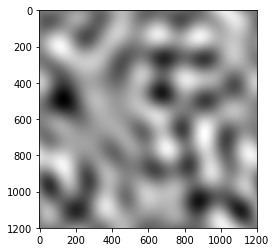

Reconstruction


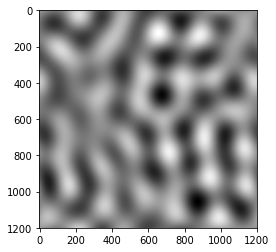

<Figure size 432x288 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

def gradient(imap,ly,lx):
    # Filter the map by (i ly, i lx) to get gradient
    return filter_map(imap,ly*1j),filter_map(imap,lx*1j)

def div(imapy,imapx,ly,lx):
    # Return divergence grad(Y)_y + grad(X)_x
    gy = gradient(imapy,ly,lx)
    gx = gradient(imapx,ly,lx)
    return gy[0] + gx[1]

def get_modlmap(imap):
    # Get absolute values of wavenumbers in map
    # Replace with numpy-based |ell| map function
    return imap.modlmap()

def filter_map(imap,filter2d):
    # Filter a map given a 2D Fourier filter
    # Replace with numpy-based winter-school filtering function
    from orphics import maps
    return maps.filter_map(imap,filter2d)

def kmask(filter2d,modlmap,ellmin,ellmax):
    # Apply a minimum and maximum multipole mask to a filter
    filter2d[modlmap<ellmin] = 0
    filter2d[modlmap>ellmax] = 0
    return filter2d

def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    The simplest form of the quadratic estimator is

    kappa_recon = - div ( grad(T) T )
    where grad(T) is Wiener filtered with (unlensed_cmb_power/total_cmb_power)
    and T is filtered with (1/total_cmb_power)
    where the T map is beam deconvolved and
    where total_cmb_power = lensed_cmb_power + noise_power / beam^2

    The reconstruction is limited to ellmin < ells < ellmax of the CMB temperature map.

    The grad and div operations require knowledge of:
    modlmap: absolute wavenumbers of Fourier pixels
    ly: map of ly Fourier coordinate of each pixel
    lx: map of lx Fourier coordinate of each pixel
    (note modlmap = sqrt(ly**2 + lx**2) )
    """
    inv_noise_filter = kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = gradient(tmap,ly,lx)

    filtered_gradTy = filter_map(gradTy,grad_filter)
    filtered_gradTx = filter_map(gradTx,grad_filter)
    filtered_T = filter_map(tmap,inv_noise_filter)
    
    ukappa = div(filtered_T * filtered_gradTy, filtered_T * filtered_gradTx, ly, lx)

    return -ukappa

def get_lensed_map():
    # Get a kappa map and a lensed CMB temperature map
    # Replace this with winter-school numpy-based code
    from orphics import maps,io,cosmology,stats,lensing
    from pixell import enmap
    flsims = lensing.FlatLensingSims(shape,wcs,theory,beam_arcmin,noise_uk_arcmin)
    unlensed,kappa,lensed,beamed,noise_map,tmap = flsims.get_sim(return_intermediate=True)
    return unlensed,kappa,lensed,beamed,noise_map,tmap

def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Just a simple interpolator that fills with zeros by default
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)
    
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))


deg = 40. # patch width in degrees
px = 2. # pixel size in arcminutes
beam_arcmin = 1.5
noise_uk_arcmin = 0.1
# ell ranges for reconstruction
ellmin = 10
ellmax = 3000

#### Generate a kappa map and a lensed CMB map
# Replace with winter-school code
from orphics import maps,cosmology
shape,wcs = maps.rect_geometry(width_deg=deg,px_res_arcmin=px)
theory = cosmology.default_theory()
unlensed,kappa,lensed,beamed,noise_map,tmap = get_lensed_map()

## CMB theory spectra
# Replace with numpy/camb based winter-school code
ells = np.arange(0,5000,1)
theory = cosmology.default_theory()
lcltt = theory.lCl('TT',ells)
ucltt = theory.uCl('TT',ells)

### Prepare 2D Fourier space interpolations of theory spectra
modlmap = get_modlmap(tmap) # absolute wavenumber map
unlensed_cmb_power_2d = interp(ells,ucltt)(modlmap)
beam2d = gauss_beam(modlmap,beam_arcmin)
noise2d = (noise_uk_arcmin*np.pi/180./60.)**2.
total_cmb_power_2d = interp(ells,lcltt)(modlmap) + noise2d/beam2d**2.

### Get Fourier wavenumber maps : replace with winter-school code
from pixell import enmap
ly,lx = enmap.laxes(shape,wcs)
ly = ly[:,None]
lx = lx[None,:]

### Beam deconvolve map
tmap = filter_map(tmap,1/beam2d)

### Get the unnormalized reconstruction
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)

### Filter the reconstruction and the input kappa to the same ellrange (where the normalization
### is expected to be relatively white)
kellmin = 10
kellmax = 60
ukappa_f = filter_map(ukappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = filter_map(kappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Plot the filtered maps for comparison
print("Input")
plt.imshow(ikappa_f,cmap='gray')
plt.show()
print("Reconstruction")
plt.imshow(ukappa_f,cmap='gray')
plt.show()
plt.clf()




## Cross power with input

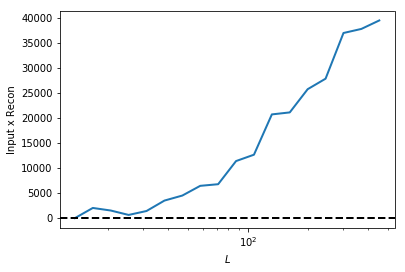

In [5]:
### Calculate binned 1d cross-power between reconstruction and input
# Replace with winter school code
cents,cross = maps.binned_power(ukappa,imap2=kappa,bin_edges = np.geomspace(ellmin,500,20))

# Plot the binned powers
plt.plot(cents,cross,lw=2)
plt.axhline(y=0.,ls='--',color='k',lw=2)
plt.xlabel('$L$')
plt.ylabel('Input x Recon')
plt.xscale('log')
plt.show()
